# **Setting & Introduction**

## **1. Github 연동**

In [1]:
""" github 연동 """
# !git clone https://github.com/ku-sungsukim/2025-LGElec-Day22.git ### colab 사용 시

' github 연동 '

## **2. About Jupyter Notebook**

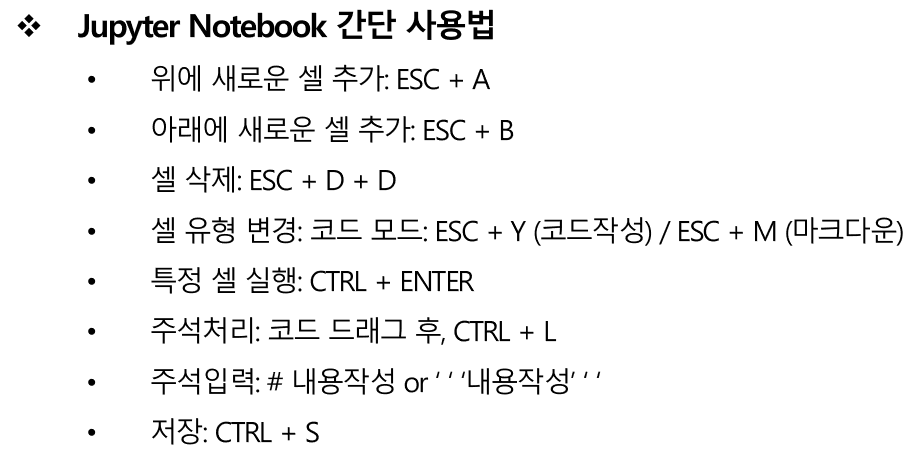

In [2]:
""" 설명 장표 불러오기 """
from IPython.display import Image
Image('image/1-Introduction2.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/1-Introduction2.PNG') ### colab 사용 시

## **[Data Balancing & XAI 실습 목차]**
 - (1) Data Balancing (1) - UnderSampling

 - (2) Data Balancing (2) - Oversampling 

 - ***(3) XAI √***

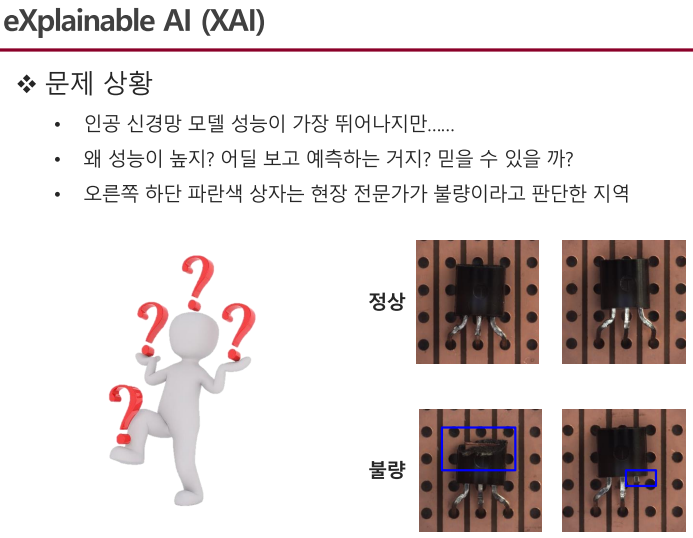

In [3]:
""" 설명 장표 불러오기 """
Image('image/9-XAI1.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/9-XAI1.PNG') ### colab 사용 시

## **[XAI - Tabular 목차]**

  - LIME

  - SHAP

## **0. 모델링 환경 설정**

#### **0-1. 필요 패키지 불러오기**

In [4]:
""" 필요 패키지 설치 """
!pip install lime

In [5]:
""" 필요 패키지 설치 """
!pip install shap

In [6]:
""" 실습에 필요한 패키지 불러오기 """


""" 기본 연산과 관련된 패키지 """
import itertools
import numpy as np
import pandas as pd


""" 모델링 및 성능 산출과 관련된 패키지"""
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


""" XAI 패키지 """
import shap
shap.initjs()
from shap import TreeExplainer
from lime.lime_tabular import LimeTabularExplainer


""" 시각화 패키지 """
import matplotlib.pyplot as plt


""" 경고 숨기기 """
import warnings
warnings.filterwarnings('ignore')

#### **0-2. 필요 함수 사전 정의**

In [7]:
""" (1) Confusion Matrix를 시각화하는 함수 """

def plot_confusion_matrix(confusion_matrix, classes):

    ### Confusion Matrix 시각화
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    ### X축 및 Y축 눈금에 Class 표시
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    ### Confusion Matrix 숫자 기입
    thresh = confusion_matrix.max() / 2. ### 폰트 색상 지정을 위한 Threshold
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'), ### 숫자 작성
                 horizontalalignment="center", ### 숫자를 각 행렬 가운데 작성
                 color="white" if confusion_matrix[i, j] > thresh else "black") ### Threshold에 따라 글자 색상 다르게 지정

    ### X축 및 Y축 레이블 표기
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    ### 이미지 크기 최적화 및 시각화
    plt.tight_layout()
    plt.show()

In [8]:
""" (2) 성능 평가 Metric을 산출하는 함수 """

"""
macro: Class 불균형을 고려한 성능지표
"""

def calculate_classification_metrics(true_labels, predicted_labels):
    
    ### 성능지표 산출
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    ### Log
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    
    return accuracy, precision, recall, f1

## **1. 실습 데이터셋 확보**

 - 데이터: Adult 데이터 (사람의 개인정보를 기반으로 "수입>50k 여부" 이진 분류) - 32,561 X 15

 - 입력변수: Age, Workclass, fnlwgt, Education, ..., Country (15개)

 - 출력변수: Income

In [9]:
""" 데이터셋 불러오기"""

### 데이터셋 경로 지정
data_dir = 'data/adult.data' ### 로컬 사용 시
# data_dir = '/content/2025-LGElec-Day22/data/adult.data' ### colab 사용 시 

### 데이터셋 불러오기
df = pd.read_csv(data_dir, header=None)
df.columns = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num",
                "Marital Status","Occupation", "Relationship", "Race", "Sex",
                "Capital Gain", "Capital Loss","Hours per week", "Country", "Income"]

df

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [10]:
""" 변수 타입 별 분류 """

col_categorical, col_numerical, col_target = [], [], []

for col, type_ in df.dtypes.to_dict().items():
    if col == 'Income': ### Y변수
        col_target.append(col)
    elif str(type_) == 'int64': ### X변수 & 수치형
        col_numerical.append(col)
    elif str(type_) == 'object': ### X변수 & 문자형
        col_categorical.append(col)
        
print(f"Categorical X변수: {len(col_categorical)}개 --> {col_categorical}")
print(f"Numercial X변수: {len(col_numerical)}개 --> {col_numerical}")
print(f"Y변수: {len(col_target)}개 --> {col_target}")

Categorical X변수: 8개 --> ['Workclass', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
Numercial X변수: 6개 --> ['Age', 'fnlwgt', 'Education-Num', 'Capital Gain', 'Capital Loss', 'Hours per week']
Y변수: 1개 --> ['Income']


In [11]:
""" Y변수 Label Encoding """

"""
Label Encoding: 문자형 변수를 수치형으로 Mapping
 - <=50K --> 0
 - >50K --> 1
"""

scaler_LB = LabelEncoder()
df[col_target[0]] = scaler_LB.fit_transform(df[col_target[0]])
df[col_target[0]]

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: Income, Length: 32561, dtype: int32

In [12]:
""" X 내 범주형 변수 One-hot Encoding """

"""
One-hot Encoding: 문자형 변수들을 포함 여부에 따라서 구분
 - Country: Korea, Japan, China --> Country_Korea / Country_Japan / Country_China (각 변수 값은 True/False로 표기)
"""

cat_dummy = pd.get_dummies(df[col_categorical].astype(str))
cat_dummy

,Workclass_ ?,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,Education_ 10th,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32557,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32558,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32559,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [13]:
""" 모델링을 위해 필요한 변수들을 결합 """
df = pd.merge(df[col_numerical+col_target], cat_dummy, how='left', left_index=True, right_index=True)
df

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Income,Workclass_ ?,Workclass_ Federal-gov,Workclass_ Local-gov,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,83311,13,0,0,13,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,38,215646,9,0,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,53,234721,7,0,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,28,338409,13,0,0,40,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32557,40,154374,9,0,0,40,1,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32558,58,151910,9,0,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32559,22,201490,9,0,0,20,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [14]:
""" Boolean Column을 Int로 변환 """
bool_columns = df.select_dtypes(include=['bool']).columns
df[bool_columns] = df[bool_columns].astype(int)
df

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Income,Workclass_ ?,Workclass_ Federal-gov,Workclass_ Local-gov,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,40,154374,9,0,0,40,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,58,151910,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32559,22,201490,9,0,0,20,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [15]:
""" 데이터 분할 """
col_categorical_onehot = cat_dummy.columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(df[col_numerical+col_categorical_onehot],
                                                          df[col_target],
                                                          train_size=0.8,
                                                          random_state=2025)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26048, 108), (6513, 108), (26048, 1), (6513, 1))

## **2. Base 모델 학습**

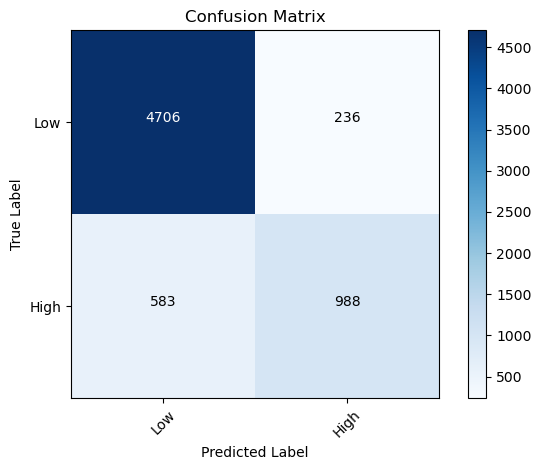

Accuracy : 0.8743
Precision : 0.8485
Recall : 0.7906
F1-score : 0.8135


In [16]:
""" GBM 모델링 """

### 모델 Train & Test
model_gb = GradientBoostingClassifier(n_estimators=100, random_state=2025)
model_gb.fit(X_train, y_train)
y_pred_test = model_gb.predict(X_test)

### Confusion Matrix 시각화 및 성능 산출
classes = ['Low', 'High'] ### Low: 소득이 낮다 // High: 소득이 높다
cm_baseline = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm_baseline, classes)
_, _, _, f1_baseline = calculate_classification_metrics(y_test, y_pred_test)

## **3. LIME**

 - https://lime-ml.readthedocs.io/en/latest

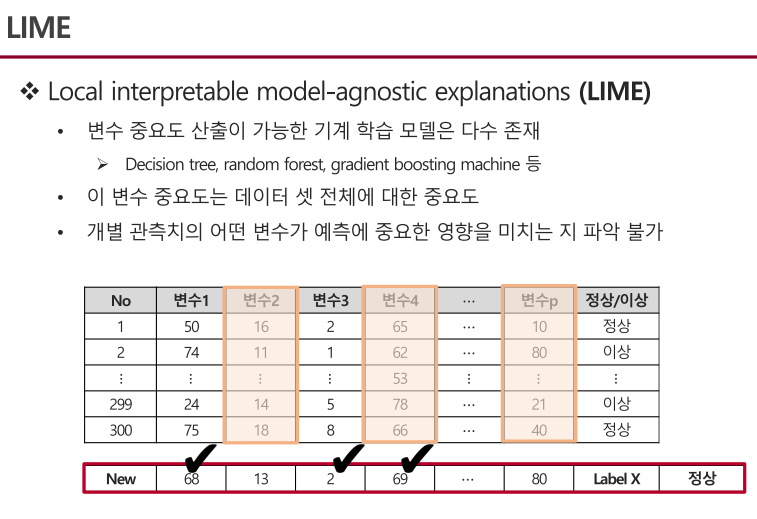

In [17]:
""" 설명 장표 불러오기 """
Image('image/9-XAI2.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/9-XAI2.PNG') ### colab 사용 시

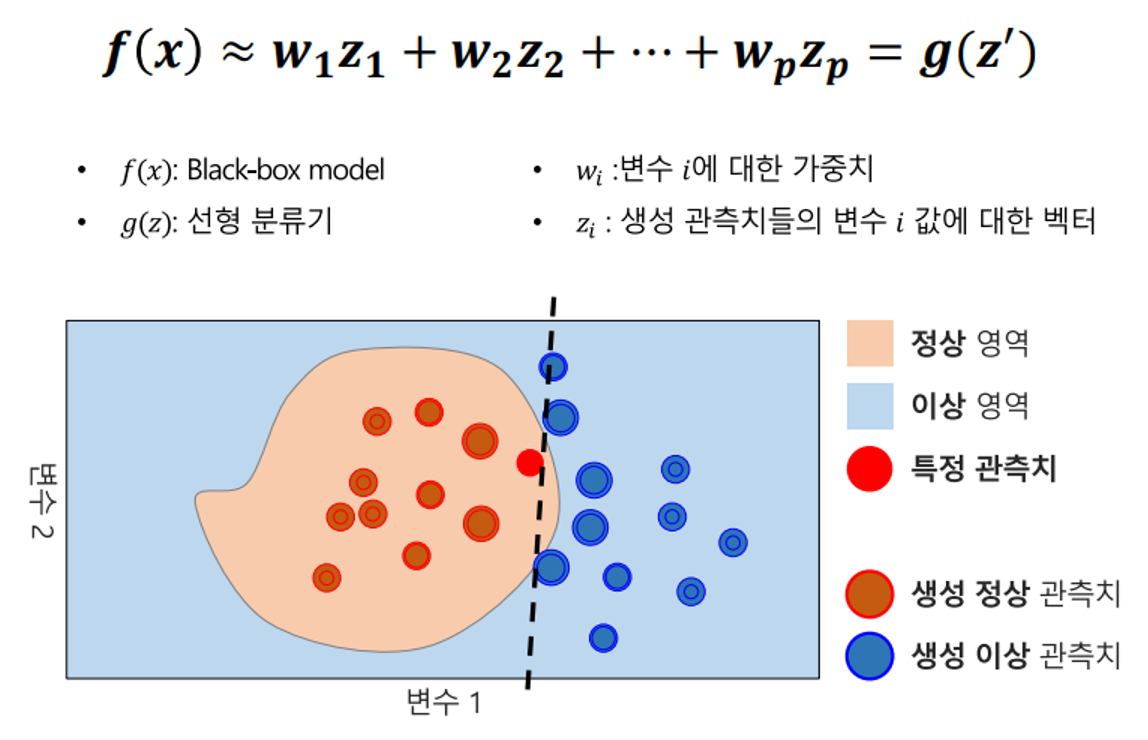

In [18]:
""" 설명 장표 불러오기 """
Image('image/9-XAI3.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/9-XAI3.PNG') ### colab 사용 시

In [19]:
""" LIME Explainer 정의 """
explainer = LimeTabularExplainer(training_data=X_train.values,
                                 mode='classification', ### Task
                                 feature_names=X_train.columns, ### X변수명
                                 categorical_features=col_categorical_onehot, ### X변수 중 Categorical 변수들
                                 class_names=['<=50K', '>50K'] ### Y의 Class
                                 )

In [20]:
""" Test 데이터의 0번째 관측치에 대한 결과 시각화 """
predict_fn = lambda x: model_gb.predict_proba(x)
exp = explainer.explain_instance(data_row=X_test.values[3], ### Test하고자 하는 Instance
                                 predict_fn=predict_fn, ### 기존에 학습한 모델
                                 num_features=5) ### 상위 몇개의 Feature 결과 확인할 것인지
exp.show_in_notebook()

## **4. SHAP**

 - https://shap.readthedocs.io/en/latest/

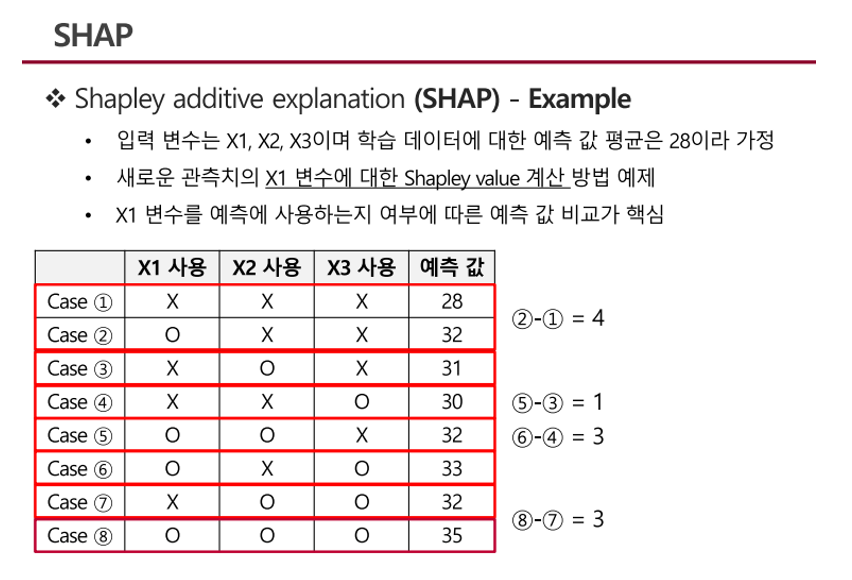

In [21]:
""" 설명 장표 불러오기 """
Image('image/9-XAI4.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/9-XAI4.PNG') ### colab 사용 시

In [22]:
""" SHAP Explainer 정의 후, SHAP Value 산출 """
explainer = TreeExplainer(model=model_gb,
                          data=X_train)
shap_values = explainer(X=X_test)

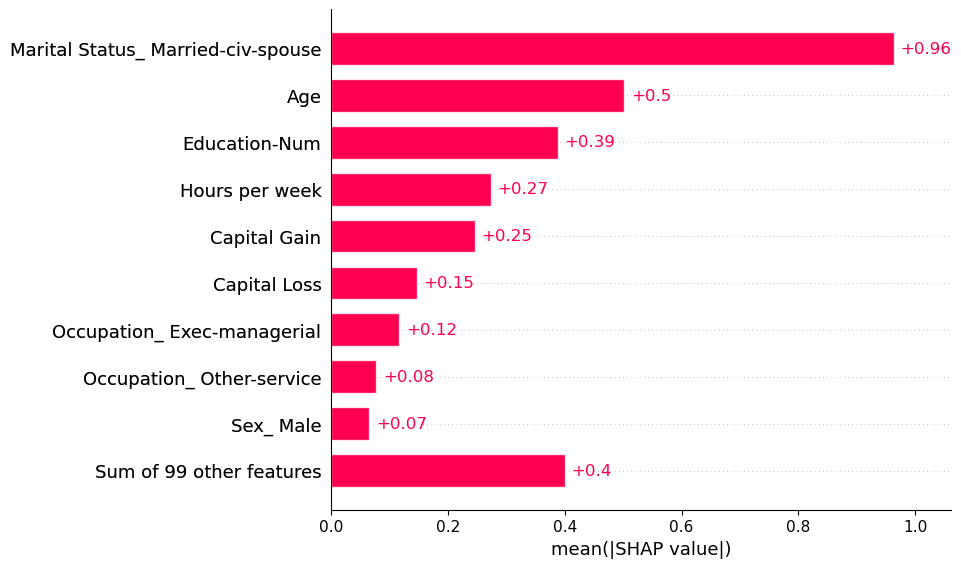

In [23]:
""" 전체 데이터셋 수준(Global) 변수 중요도 파악 """
shap.plots.bar(shap_values=shap_values)

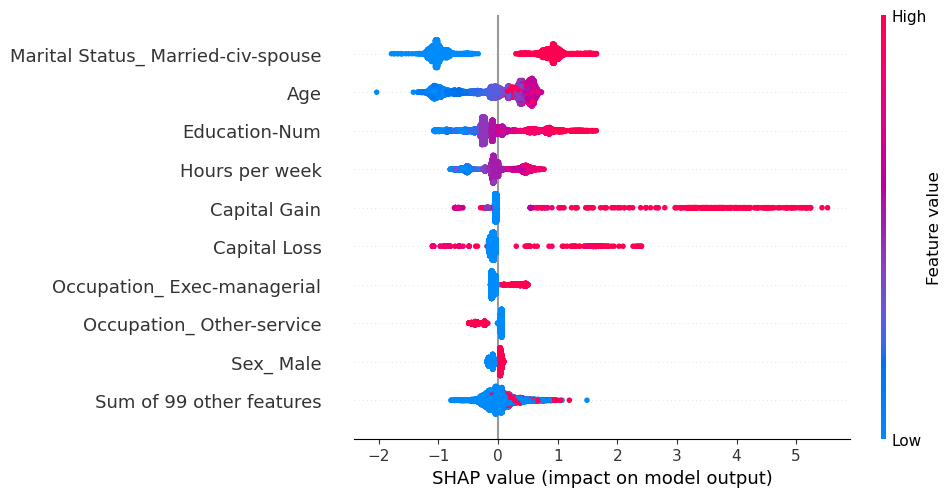

In [24]:
""" 전체 데이터셋 수준(Global) 상세 변수 중요도 파악 """

"""
Captital Gain: 큰 값을 가질수록 출력값이 커지는 방향으로 큰 영향을 크게 끼침
"""

shap.plots.beeswarm(shap_values)

예측결과 : Class0


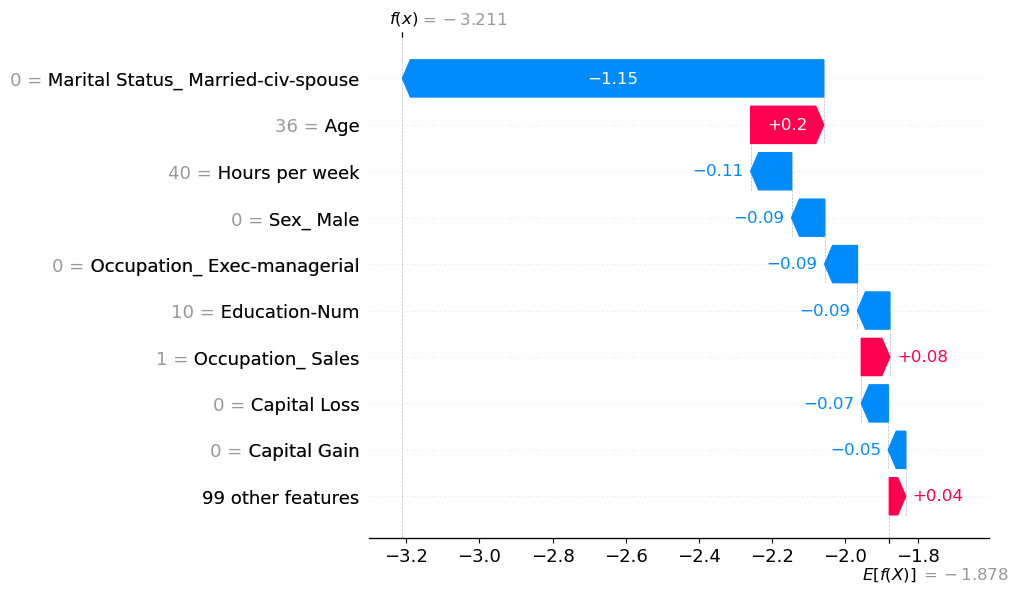

In [25]:
""" 특정 관측치 수준(Local) 상세 변수 중요도 파악 """

"""
f(x): 현재 Sample의 Logit값
E(f(x)): 전체 Sample Logit값의 평균
빨간색: Logit값을 높이는데 기여한 정도
파란색: Logit값을 낮추는데 기여한 정도
"""

sample_idx = 1
print(f'예측결과 : Class{y_pred_test[sample_idx]}')
shap.plots.waterfall(shap_values[sample_idx])

In [26]:
""" Logit을 확률로 변환하여 확인 """
instance_logit = -3.211
average_logit = -1.878
instance_probability = 1 / (1 + np.exp(-instance_logit))
average_probability = 1 / (1 + np.exp(-average_logit))

print(f'Instance 확률: {round(instance_probability, 3)}')
print(f'평균 확률: {round(average_probability, 3)}')

Instance 확률: 0.039
평균 확률: 0.133


In [27]:
""" 실제 Class의 분포 확인 """
y_test['Income'].value_counts()

Income
0    4942
1    1571
Name: count, dtype: int64

예측결과 : Class1


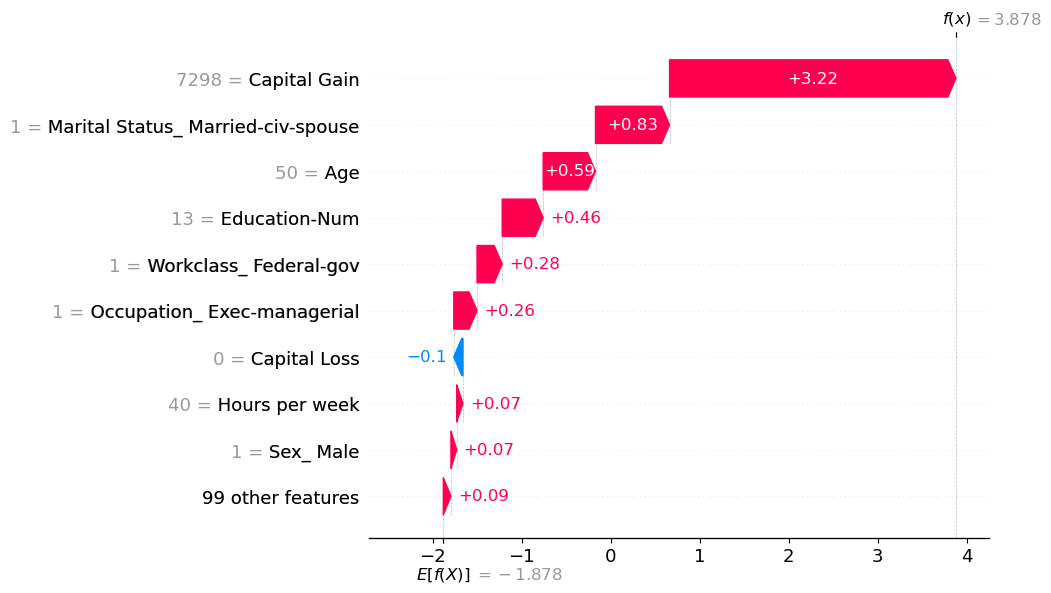

In [28]:
""" 특정 관측치 수준(Local) 상세 변수 중요도 파악 """

"""
f(x): 현재 Sample의 Logit값
E(f(x)): 전체 Sample Logit값의 평균
빨간색: Logit값을 높이는데 기여한 정도
파란색: Logit값을 낮추는데 기여한 정도
"""

sample_idx = 2
print(f'예측결과 : Class{y_pred_test[sample_idx]}')
shap.plots.waterfall(shap_values[sample_idx])

In [29]:
""" Logit을 확률로 변환하여 확인 """
instance_logit = 3.878
average_logit = -1.878
instance_probability = 1 / (1 + np.exp(-instance_logit))
average_probability = 1 / (1 + np.exp(-average_logit))

print(f'Instance 확률: {round(instance_probability, 3)}')
print(f'평균 확률: {round(average_probability, 3)}')

Instance 확률: 0.98
평균 확률: 0.133


In [30]:
""" 특정 관측치 수준(Local) 상세 변수 중요도 파악 """

"""
f(x): 현재 Sample의 Logit값
빨간색: Logit값을 높이는데 기여한 정도
파란색: Logit값을 낮추는데 기여한 정도
"""

sample_idx = 1
print(f'예측 레이블 : {y_pred_test[sample_idx]}')
shap.plots.force(explainer.expected_value, shap_values.values[sample_idx], features=X_test.iloc[sample_idx])

예측 레이블 : 0


In [31]:
""" 특정 관측치 수준(Local) 상세 변수 중요도 파악 """

"""
f(x): 현재 Sample의 Logit값
빨간색: Logit값을 높이는데 기여한 정도 
파란색: Logit값을 낮추는데 기여한 정도 
"""

sample_idx = 2
print(f'예측 레이블 : {y_pred_test[sample_idx]}')
shap.plots.force(explainer.expected_value, shap_values.values[sample_idx], features=X_test.iloc[sample_idx])

예측 레이블 : 1


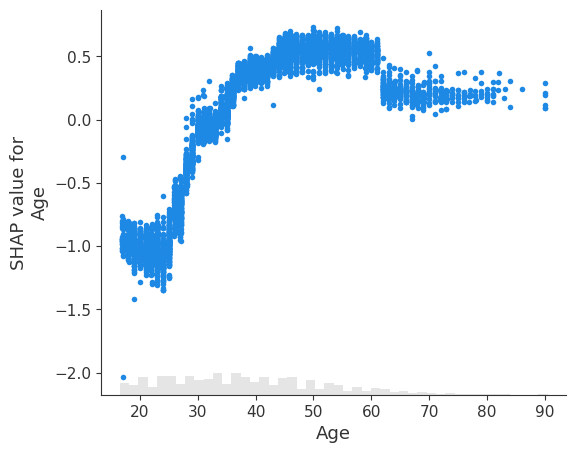

In [32]:
""" 특정 변수와 SHAP Value 간 상관관계 파악 """

"""
Age
 (1) 값이 작을수록 예측값이 작아지는데 큰 영향을 미침
 (2) 값이 클수록 예측값이 커지는데 큰 영향을 미침
   ex1) 2~30대: 낮은 예측값에 큰 기여
   ex2) 3~40대: Age가 큰 기여를 하지 못함
   ex3) 5~60대: 높은 예측값이 큰 기여
"""

shap.plots.scatter(shap_values[:, 'Age'])

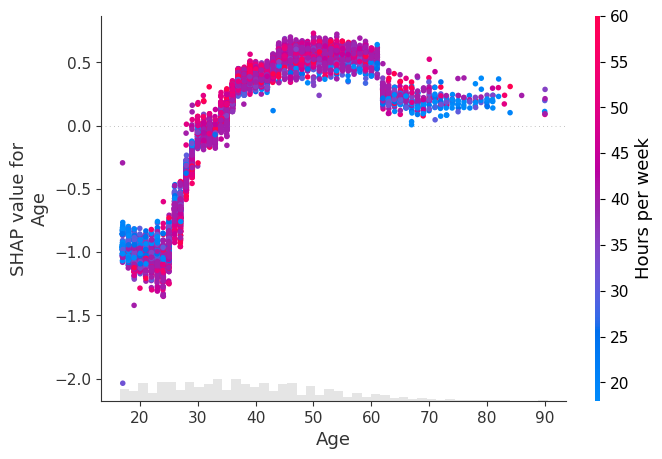

In [33]:
""" SHAP에 대한 변수간 교호작용 가능 파악 """

"""
(1) Age와 Hours per week가 모두 클 때 (5~60대), SHAP은 큰 경향을 보임 --> 높은 예측값에 크게 작용
(2) Age와 Hours per week가 모두 작을 때, SHAP은 낮은 경향을 보임 --> 낮은 예측값에 크게 작용
"""
shap.plots.scatter(shap_values[:, 'Age'], color=shap_values[:, 'Hours per week'])